## Домашняя работа №2. Сообщества в сетях
### Выполнили: Максимов Артем, Залесская Галина, Елькина Варвара
### Метод Кернигана-Лина нахождения бинарного разбиения графа


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Посмотрим на принцип работы функции planted_partition_graph. Она принимает на вход 4 параметра: количество кластеров, количество вершин в них и вероятности связи внутри кластера и между ними.
Для примера построим граф с максимальной связью внутри кластера и минимальной - снаружи.

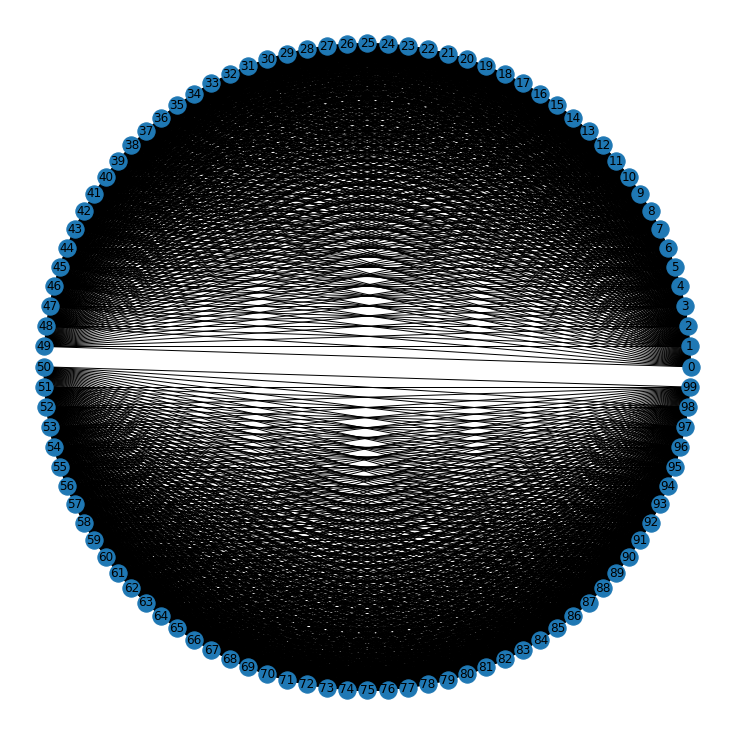

In [67]:
graph = nx.planted_partition_graph(2, 50, 1, 0)
plt.figure(figsize=(10,10))
nx.draw_shell(graph, with_labels=True)

Что важно, номера вершин в каждом кластере идут по порядку. В данном примере все вершины до 50-й принадлежат одному кластеру, после - другому.

Для реализации функции rand_index была использована следующия структура данных:

Словарь, ключами которого являются ребра, а значениями - флаги 0/1. Флаг 0 просталялся для случаев когда оба конца ребра находятся в одном разбиении графа, и 1 - если в разных.

Изначальное разбиение получалось следующим образом:
    
  - 0...(N/2-1) вершины принадлежат разбиению 1;
  - N/2...N принадлежат разбиению 2.

Это обусловлено работой генератора planted partition графа из библиотеки NetworkX.

С ним сравнивалось разбиение на кластеры, полученное алгоритмом Кернигана-Лина, также реализованного в данной библиотеке.

In [2]:
def graph_to_edge_structure(graph, partition):
    (Cluster1,Cluster2) = partition
    Edges = [(X,Y) for (X,Y,_) in list(nx.to_edgelist(graph))]
    Structure = dict()
    for (X,Y) in Edges:
        if (X in Cluster1 and Y in Cluster1) or (X in Cluster2 and Y in Cluster2):
            Structure[(X,Y)] = 0;
        else:
            Structure[(X,Y)] = 1
    return Structure

Для обоих разбиений - до и после кластеризации строилась указанная выше структура и после этого словари построчно сравнивались.

Выделялись следующие случаи:

  - Группа А. В обеих структурах значения совпадали и были равны 0. Это означает, что в обоих разбиениях обе вершины ребра находились в одном кластере.
  - Группа В. В обеих структурах значения совпадали и были равны 1. Это означает, что в обоих разбиениях вершины ребра находились в разных кластерах.
  - Группа С. Значение в первой структуре было меньше значения во второй. Это означает, что до кластеризации обе вершины были в одном кластере, а после оказались в разных.
  - Группа D. Значение в первой структуре было больше значения во второй. Это означает, что до кластеризации вершины были в в разных кластерах, а после оказались в одном.

На основе количества элементов, попавших в разные группы, значение Rand Index считалось по следующей формуле:
    
    RandIndex = [size(A) + size(B)] / [size(A) + size(B) + size(C) + size(D)]

In [29]:
def rand_index(graph, partition): 
#     partiton = (Cluster1,Cluster2) the output of clustering method
    
    Structure1 = graph_to_edge_structure(graph,([i for i in range(50)],[i for i in range(50, 100)]))
    Structure2 = graph_to_edge_structure(graph, partition)
    classes=[0,0,0,0]
    
#     print("Partition: {}\n".format(partition))
    for row in Structure1:
        if Structure1[row] == Structure2[row] == 0:
            classes[0] += 1;
        elif Structure1[row] == Structure2[row] == 1:
            classes[1] += 1;
        elif Structure1[row] < Structure2[row]:
            classes[2] += 1;
        else:
            classes[3] += 1
    
#     print("Classes: {}\n".format(classes))
    assert np.sum(classes) == len(list(nx.to_edgelist(graph))), "Wrong number!"
    
    r_index = (classes[0] + classes[1])/np.sum(classes)
    return r_index

d = (n1-1) * p_in + (n2-1) * p_out

Подставив заданные значения для данного эксперимента, получим:
16 = 49 * (p_in + p_out)

16 / 49 = p_in + p_out 

#### max_p_out = 16 / 49, достигается при p_in = 0

Посмотрим, как выглядят предельные случаи для условий данного эксперимента: при минимальной связи между кластерами (min_p_out = 0) и максимальной (max_p_out = 16 / 49)

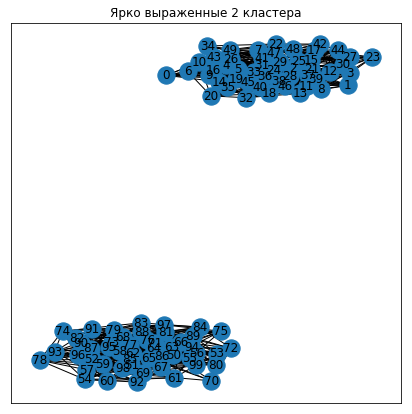

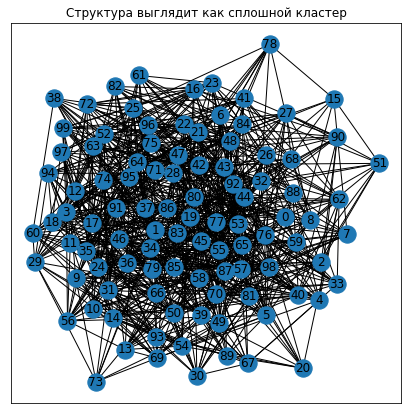

In [58]:
max_p = 16 / 49
graph = nx.planted_partition_graph(2,50, max_p, 0)
plt.figure(figsize=(7,7))
plt.title("Ярко выраженные 2 кластера")
nx.draw_networkx(graph, with_labels=True)


graph = nx.planted_partition_graph(2,50, 0, max_p)
plt.figure(figsize=(7,7))
plt.title("Структура выглядит как сплошной кластер")
nx.draw_networkx(graph, with_labels=True)

При p_in == p_out структура так же напоминает единый кластер

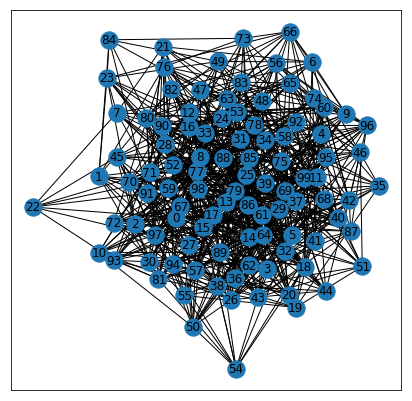

In [59]:
graph = nx.planted_partition_graph(2,50, max_p/2, max_p/2)
plt.figure(figsize=(7,7))
nx.draw_networkx(graph, with_labels=True)

In [22]:
from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection

Посмотрим, как изменяется значение Rand index при изменении вероятности связи между кластерами от минимального к максимальному

In [61]:
rand_indexes = [[]]*10
for k in range(1, 10):
    p_out = k/10 * max_p_out
    graph = nx.planted_partition_graph(2, 50, max_p_out - p_out, p_out)
    rand_indexes[k] = []
    for _ in range(200):
        rand_indexes[k].append(rand_index(graph, kernighan_lin_bisection(graph, max_iter=10)))
    rand_indexes[k] = np.mean(rand_indexes[k])

In [65]:
for k in range(1, 10):
    p_out = k/10 * max_p_out
    print("If p_out is {}, rand index is {}".format(p_out, rand_indexes[k]))

If p_out is 0.03265306122448979, rand index is 1.0
If p_out is 0.06530612244897958, rand index is 1.0
If p_out is 0.09795918367346938, rand index is 0.8829330708661416
If p_out is 0.13061224489795917, rand index is 0.5445263788968825
If p_out is 0.16326530612244897, rand index is 0.49495472186287187
If p_out is 0.19591836734693877, rand index is 0.4707223618090452
If p_out is 0.22857142857142854, rand index is 0.45047423887587823
If p_out is 0.26122448979591834, rand index is 0.428519656019656
If p_out is 0.29387755102040813, rand index is 0.37796019900497513


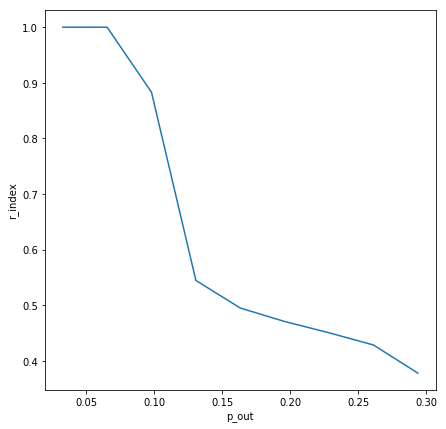

In [66]:
plt.figure(figsize=(7,7))
plt.plot([k/10 * max_p_out for k in range(1,10)], rand_indexes[1:])
plt.xlabel("p_out")
plt.ylabel("r_index")
plt.show()

В данном эксерименте rand index является мерой качества разбиения (так как сравнивается с "идеальным", изначально посеяным разбиением (0..50), (50..100)).

Из графика хорошо видно, что с увеличением вероятности связи между кластерами, качество разбиения сильно падает (это связано с тем, что даже визуально при p_out = max_p_out / 2 ~ 0.15 граф теряет кластерную структуру, в чем мы убедились выше).

Как видно, для эксперимента с бинарным разбиением графа:
   - при p_out <= max_p_out / 3 
   значение rand index близко к единице (из-за слабой связи между кластерами)
   
   
   - при max_p_out / 3 < p_out < 2 * max_p_out / 3 
   происходит резкое падение значения rand index (область фазового перехода)
   
   
   - при p_out > 2 * max_p_out / 3 
   rand index близок к минимальному значению (0.4)
    

Таким образом, для planted partition graph метод бинарного разбиения графа Кернигана-Лина хорошо работает только в случае, если p_out составляет треть и меньше от максимального значения.